<a href="https://colab.research.google.com/github/ab17254/dissertation/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [2]:
# Downloads dataset from Kaggle
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

100% 537M/537M [00:05<00:00, 141MB/s]



In [3]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/2019_all_twitter_data/2019_all_twitter_data.csv  
  inflating: /content/data/bot_data/bot_df.csv  
  inflating: /content/data/bot_data/human_df.csv  
  inflating: /content/data/clean_twitter_data/all_2019.csv  
  inflating: /content/data/clean_twitter_data/all_users.csv  
  inflating: /content/data/clean_twitter_data/pol_actor_users.csv  


In [4]:
# Reinstalls scikit learn with most recent version for added functions
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3 MB 1.1 MB/s 


In [5]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from operator import itemgetter

import re
import tweepy
from tweepy import OAuthHandler
from config import TwitterKeys

In [6]:
# Imports bot dataset as DataFrame
pol_df = pd.read_csv('/content/data/bot_data/bot_df.csv', index_col=0)
pol_df = pol_df.reset_index(drop=True)

In [7]:
def get_interactions(df):
  '''
  Takes an dataframe and returns an dataframe of interaction between an user, and the user of the tweet they shared
  :param df (DataFrame): dataframe containg tweets and users
  :return interactions_df (DataFrame): dataframe containg user and quoted user interaction
  '''
  df = df.dropna(subset=['quotedTweet_username'])
  interactions_df = pd.DataFrame(columns=['user_username', 'quotedTweet_username'])
  user = []
  mentions = []
  for row in df.iterrows():
    user.append(row[1]['user_username'])
    mentions.append(row[1]['quotedTweet_username'])

  interactions_df['user_username'] = user
  interactions_df['quotedTweet_username'] = mentions
  interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].str.split()
  interactions_df = interactions_df.dropna()

  interactions = []
  for row in interactions_df.iterrows():
    user = row[1][0]
    mentions = row[1][1]
    for mention in mentions:
      interactions.append((user, mention))

  interactions_df = pd.DataFrame(interactions, columns=['user_username', 'quotedTweet_username'])
  interactions_df = interactions_df.replace('nan', np.nan)
  interactions_df = interactions_df.dropna()
  interactions_df['user_username'] = interactions_df['user_username'].astype('str')
  interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].astype('str')
  interactions_df=interactions_df.drop([1,2])
  
  return interactions_df

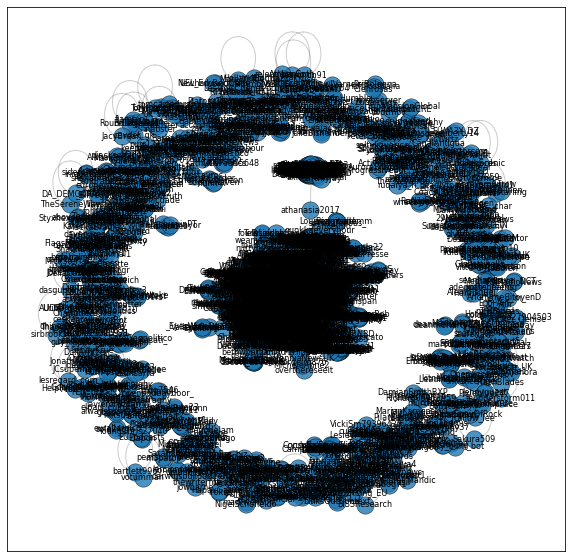

In [8]:
graph = nx.from_pandas_edgelist(get_interactions(pol_df), 'user_username', 'quotedTweet_username')
pos = nx.spring_layout(graph)

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(graph, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(graph, pos, font_size=8)
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.2)

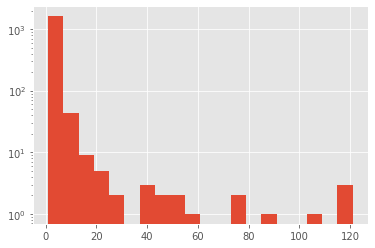

In [ ]:
def plot_degree_dist(G):
  '''
  Function to plot an histogram of the degree distribution of nodes in the graph
  '''
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, log=True, bins=20)
    plt.show()

plot_degree_dist(largest_subgraph)

In [ ]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 2571 nodes and 2541 edges present in the Graph
The maximum degree of the Graph is 121
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 2.0
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 367 connected components in the Graph


In [ ]:
largest_subgraph=list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

    
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

There are 1692 nodes and 1998 edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.001870486616054812 in the largest subgraph
The transitivity of the largest subgraph is 0.0007394322803269934
The diameter of our Graph is 14
The average distance between any two nodes is 5.60


In [ ]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id pauldashworth has a degree centrality of 0.07 which is the maximum of the Graph
the node with id pauldashworth has a closeness centrality of 0.30 which is the maximum of the Graph
the node with id pauldashworth has a betweenness centrality of 0.43 which is the maximum of the Graph


In [ ]:
def g_density(g):  
  return len(g.edges()) / (((len(g.nodes())) * (len(g.nodes())-1))/2)

g_density(largest_subgraph)

0.0013966304717087962

In [ ]:
# Calculates the centrality scores for and saves to CSV file
degree_col = nx.degree_centrality(largest_subgraph)
close_col = nx.closeness_centrality(largest_subgraph)
bet_col = nx.betweenness_centrality(largest_subgraph)
degree_df = pd.DataFrame(data=degree_col.values(), index=degree_col.keys(), columns=['Degree Centrality'])
close_df = pd.DataFrame(data=close_col.values(), index=close_col.keys(), columns=['Closeness Centrality'])
bet_df = pd.DataFrame(data=bet_col.values(), index=bet_col.keys(), columns=['Betweenness Centrality'])
deg_close_df = pd.merge(left=degree_df, right=close_df, left_index=True, right_index=True)
centrality_df = pd.merge(left=deg_close_df, right = bet_df, left_index=True, right_index=True)
centrality_df.to_csv('centrality.csv')

betweenness = dict(sorted(graph_betweenness.items(), key=itemgetter(1), reverse=True)[:10])
cent = dict(sorted(graph_centrality.items(), key=itemgetter(1)))

In [ ]:
cent = {}
for node in largest_subgraph.nodes():
  if node in interactions_df['quotedTweet_username'].values:
    cent[node] = node

In [ ]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['green']
central_nodes = list(cent.keys())
label_nodes = (list(betweenness.keys()))
pos = nx.kamada_kawai_layout(largest_subgraph, scale=2)

In [ ]:
labels = {}
for node in largest_subgraph.nodes():
  if node in label_nodes:
    labels[node] = node

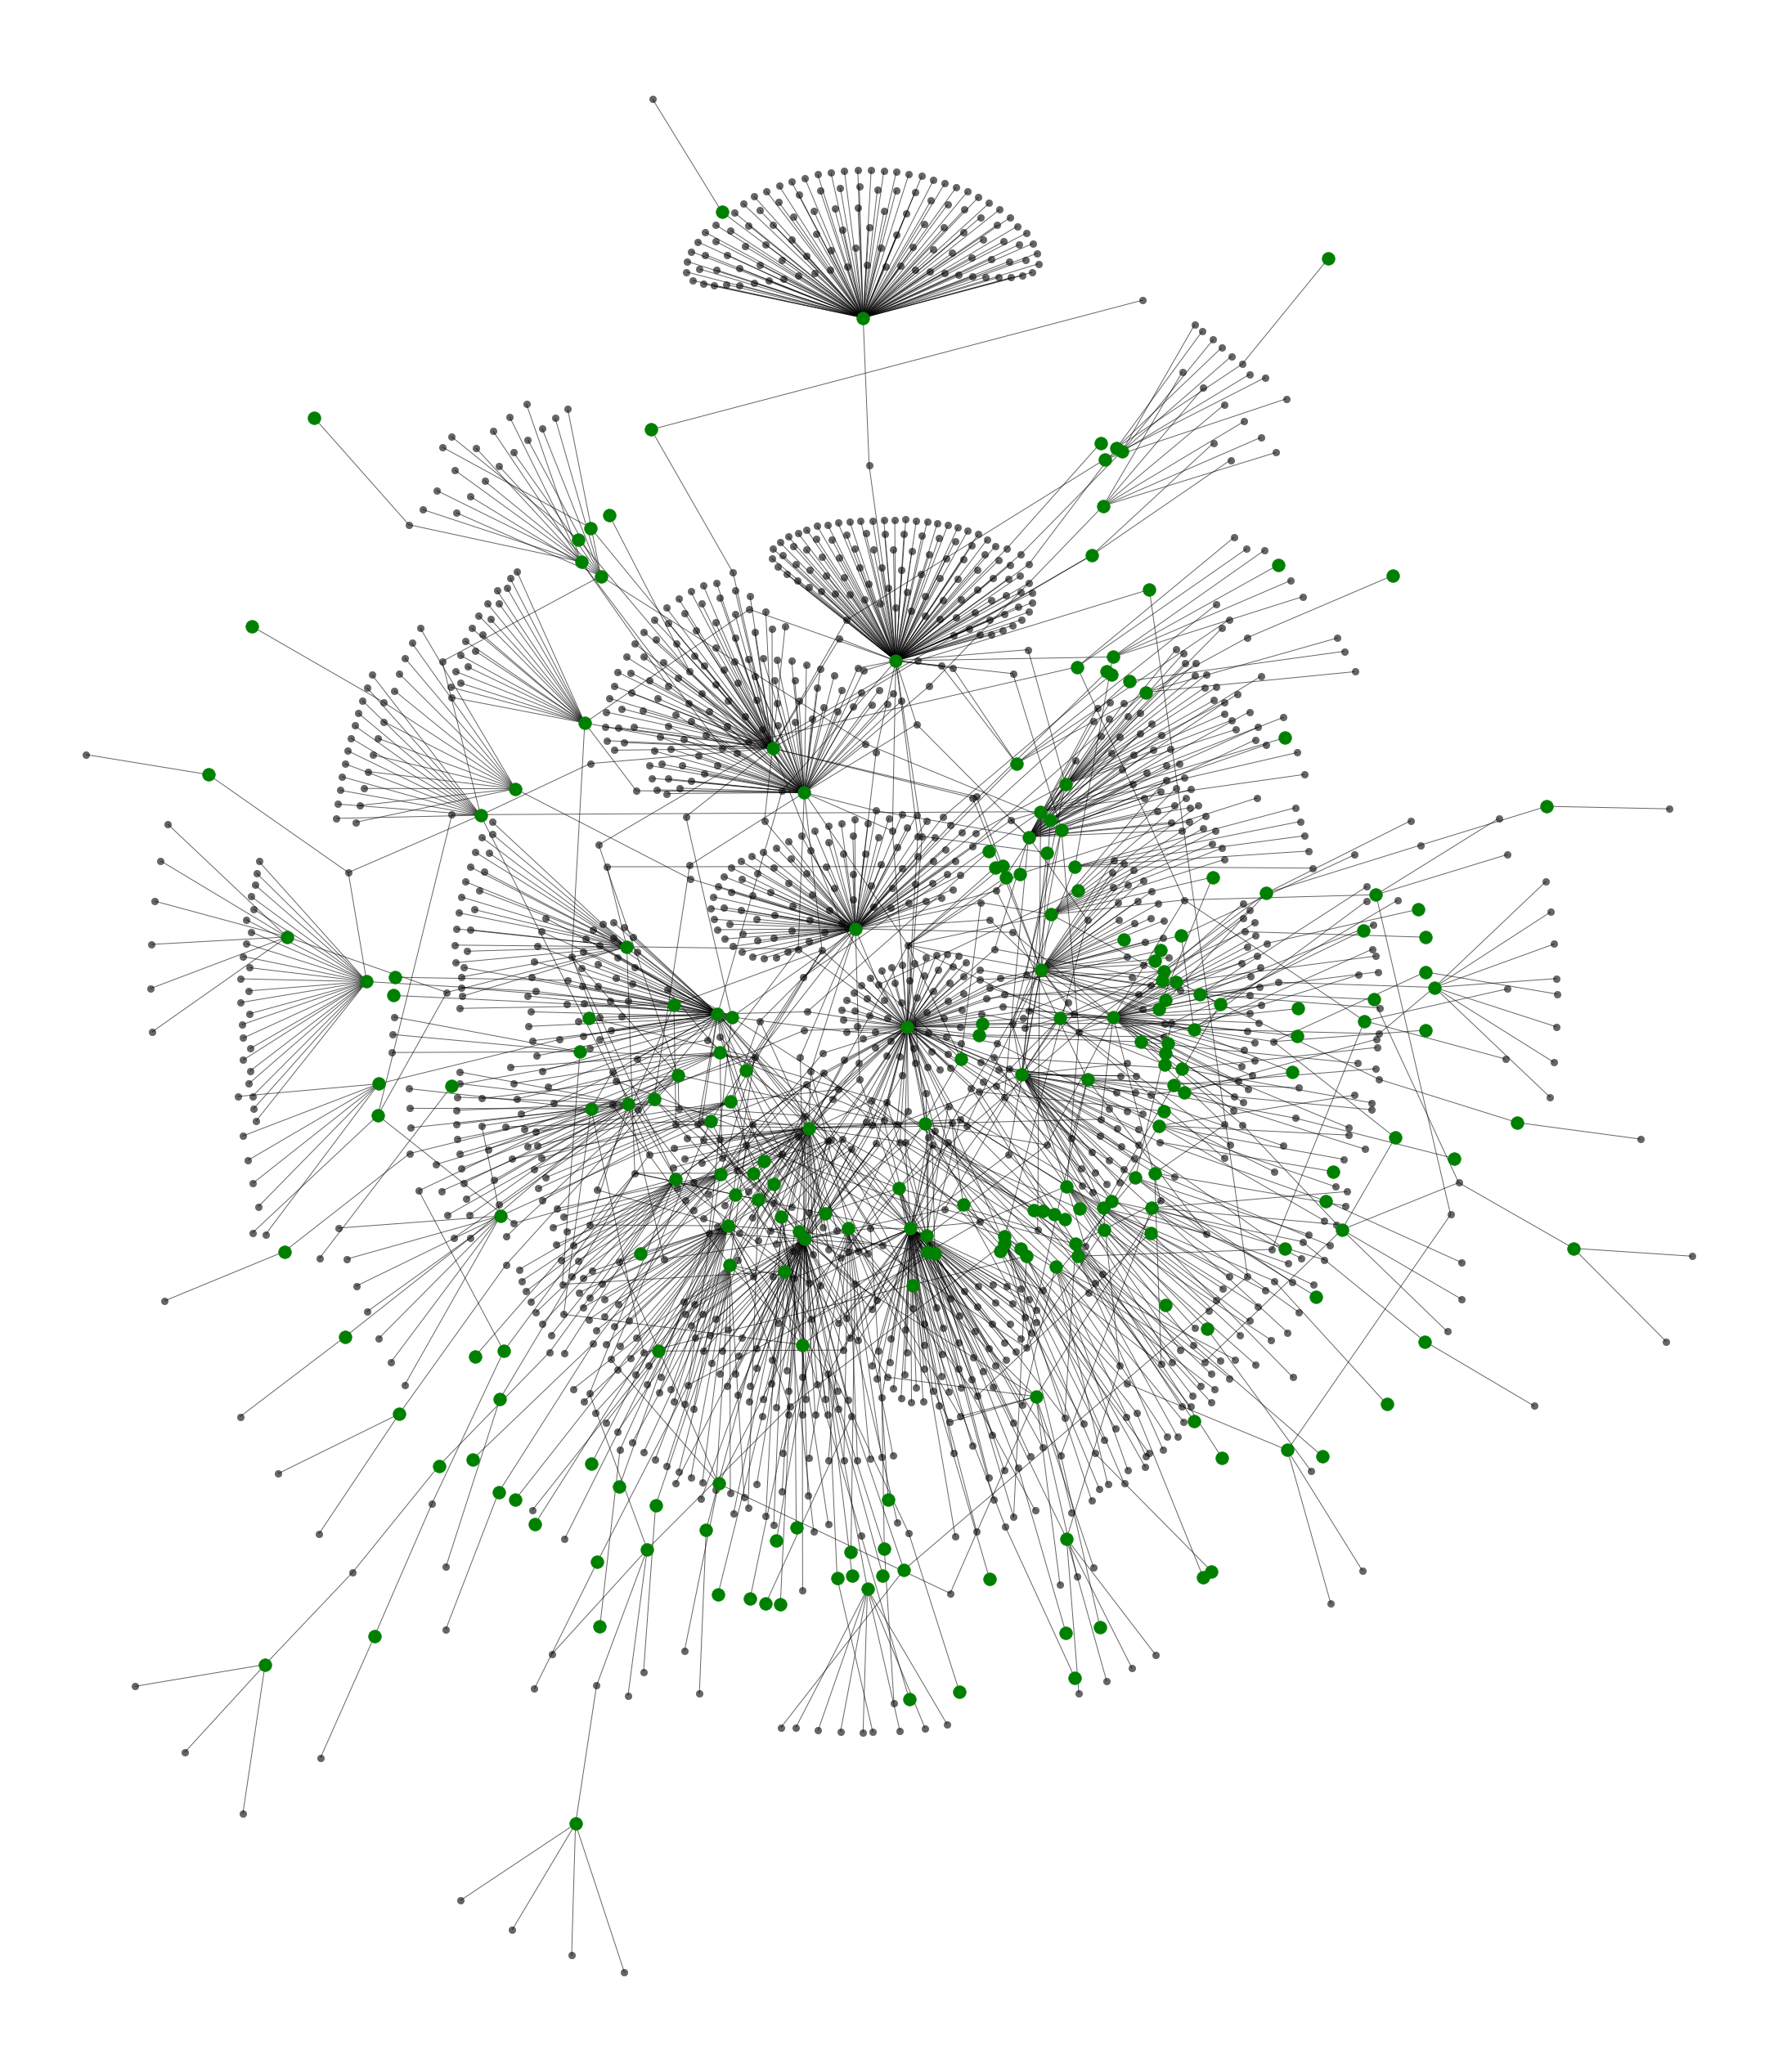

In [ ]:
plt.figure(figsize = (30,35))
nx.draw(largest_subgraph, pos=pos, node_color='k', edge_color="black", linewidths=0.3, node_size=75, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=250, node_color=colors_central_nodes)
# nx.draw_networkx_labels(largest_subgraph, pos=pos, labels=labels, font_size=32, font_color='k', font_weight='bold', bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='center')
plt.show()

In [13]:
hashtag = []
for i in pol_df['quoted_hashtags']:
  if len(i) == 2:
    hashtag.append(None)
  else:
    hashtag.append(i)
pol_df.drop(columns=['quoted_hashtags'])
pol_df['quoted_hashtags'] = hashtag

def string_to_list(s):
  '''
  Converts hashtags string into list
  '''
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    arr = []
    li = list(s.split(","))
    for elem in li:
      no_punct=''
      for char in elem:
        if char not in punctuations:
          no_punct = no_punct+char
      arr.append(no_punct.replace(' ', ''))
    return arr

def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

for row in pol_df['hashtags']:
  if row != None:
    row = string_to_list(row)


In [14]:
'''
Takes hashtags used in data collection, splits into the three positions. If an tweet contains one hashtag from the position then the new column == True
'''
right = ['#Tories', '#Tory', '#Conservatives','#VoteConservative', '#BorisJohnson', '#Boris', '#ToryManifesto','#Brexit','#brexit']

is_right = []
for i, row in enumerate(pol_df['hashtags']):
  if row != None:
    row = string_to_list(row)
    row = prepend(row, '#')
    cond = any(elem in row for elem in right)
  if row == None:
    cond = False
  is_right.append(cond)
pol_df['is_right'] = is_right

left = ['#VoteLabour', '#Labour', '#ImVotingLabour','#JC4PM','#Corbyn', '#JeremyCorbyn', '#ForTheMany', '#ForTheManyNotTheFew', '#VoteSNP', '#SNP', '#LabourManifesto','#SaveOurNHS','#VoteNHS']

is_left = []
for i, row in enumerate(pol_df['hashtags']):
  if row != None:
    row = string_to_list(row)
    row = prepend(row, '#')
    cond = any(elem in row for elem in left)
  if row == None:
    cond = False
  is_left.append(cond)
pol_df['is_left'] = is_left

center = ['#GE2019', '#GE', '#GeneralElection', '#GeneralElection2019', '#Election2019', '#BBCDebate', '#ITVDebate', '#BattleForNumber10', '#LeadersDebate', '#BBCQT', '#marr', '#Preston', '#r4today', '#NewsNight', '#BBC', '#RegistertoVote', '#Vote', '#whyVote', '#Register2Vote', '#NHS']
is_center = []
for i, row in enumerate(pol_df['hashtags']):
  if row != None:
    row = string_to_list(row)
    row = prepend(row, '#')
    cond = any(elem in row for elem in center)
  if row == None:
    cond = False
  is_center.append(cond)

pol_df['is_center'] = is_center

In [15]:
# Creates dataframes containing only tweets from each side of the debate 
right_df = pol_df.loc[pol_df['is_right'], :]
left_df = pol_df.loc[pol_df['is_left'], :]
center_df = pol_df.loc[pol_df['is_center']]

In [19]:
def plot_network(df, color):
  '''
  Function to plot network as seen above
  :param df (DataFrame): tweet DataFrame to be plotted
  :param color (String): Colour of the bot nodes
  '''
  graph = nx.from_pandas_edgelist(get_interactions(df), 'user_username', 'quotedTweet_username')
  pos = nx.spring_layout(graph)

  print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
  degrees = [val for (node, val) in graph.degree()]
  print(f"The maximum degree of the Graph is {np.max(degrees)}")   
  print(f"The minimum degree of the Graph is {np.min(degrees)}")
  print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
  print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")
  if nx.is_connected(graph):
      print("The graph is connected")
  else:
      print("The graph is not connected")
  print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

  largest_subgraph=list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
  print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
  edges present in the largest component of the Graph")
  if nx.is_connected(largest_subgraph):
      print("The graph is connected")
  else:
      print("The graph is not connected")

  print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
  print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
  print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
  print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

  graph_centrality = nx.degree_centrality(largest_subgraph)
  max_de = max(graph_centrality.items(), key=itemgetter(1))
  graph_closeness = nx.closeness_centrality(largest_subgraph)
  max_clo = max(graph_closeness.items(), key=itemgetter(1))
  graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
  max_bet = max(graph_betweenness.items(), key=itemgetter(1))
  print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
  print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
  print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

  degree_col = nx.degree_centrality(largest_subgraph)
  close_col = nx.closeness_centrality(largest_subgraph)
  bet_col = nx.betweenness_centrality(largest_subgraph)
  degree_df = pd.DataFrame(data=degree_col.values(), index=degree_col.keys(), columns=['Degree Centrality'])
  close_df = pd.DataFrame(data=close_col.values(), index=close_col.keys(), columns=['Closeness Centrality'])
  bet_df = pd.DataFrame(data=bet_col.values(), index=bet_col.keys(), columns=['Betweenness Centrality'])
  deg_close_df = pd.merge(left=degree_df, right=close_df, left_index=True, right_index=True)
  centrality_df = pd.merge(left=deg_close_df, right = bet_df, left_index=True, right_index=True)
  centrality_df.to_csv('left_centrality.csv')

  betweenness = dict(sorted(graph_betweenness.items(), key=itemgetter(1), reverse=True)[:10])
  cent = dict(sorted(graph_centrality.items(), key=itemgetter(1)))

  cent = {}
  for node in largest_subgraph.nodes():
    if node in get_interactions(df)['quotedTweet_username'].values:
      cent[node] = node

  node_and_degree = largest_subgraph.degree()
  colors_central_nodes = [color]
  central_nodes = list(cent.keys())
  label_nodes = (list(betweenness.keys()))
  pos = nx.kamada_kawai_layout(largest_subgraph, scale=2)

  labels = {}
  for node in largest_subgraph.nodes():
    if node in central_nodes:
      labels[node] = node

  plt.figure(figsize = (10,10))
  nx.draw(largest_subgraph, pos=pos, node_color='k', edge_color="black", linewidths=0.3, node_size=50, alpha=0.6, with_labels=False)
  nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=100, node_color=colors_central_nodes)
  # draw_networkx_labels(largest_subgraph, pos=pos, labels=labels, font_size=32, font_color='k', font_weight='bold', bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='center')
  plt.show()

There are 944 nodes and 726 edges present in the Graph
The maximum degree of the Graph is 35
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.5
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 239 connected components in the Graph
There are 260 nodes and 266   edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0
The diameter of our Graph is 18
The average distance between any two nodes is 6.20
the node with id guardiannews has a degree centrality of 0.14 which is the maximum of the Graph
the node with id pauldashworth has a closeness centrality of 0.29 which is the maximum of the Graph
the node with id pauldashworth has a betweenness centrality of 0.82 which is the maximum of the Graph


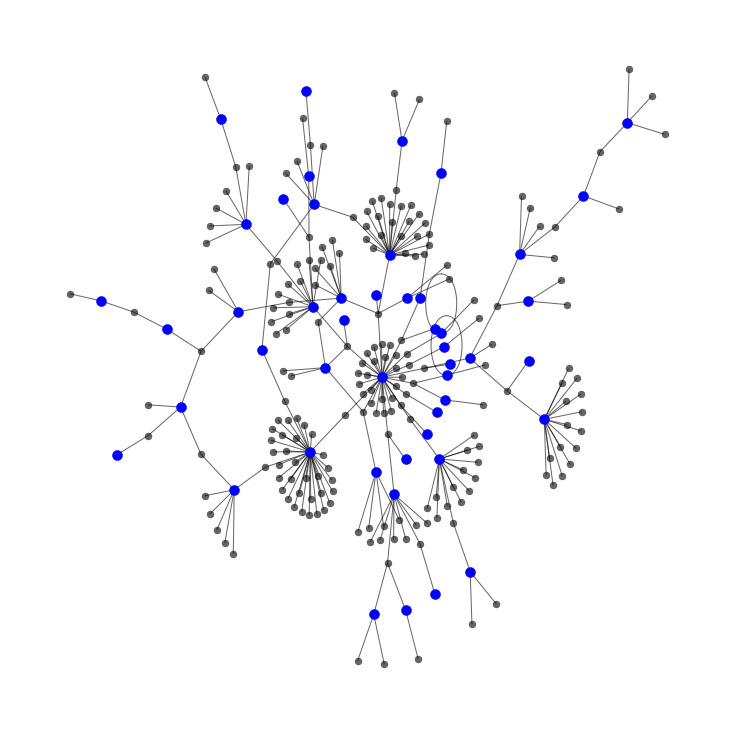

In [21]:
plot_network(right_df, 'blue')

There are 1260 nodes and 1171 edges present in the Graph
The maximum degree of the Graph is 91
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.9
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 183 connected components in the Graph
There are 802 nodes and 880   edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.003790203626688207 in the largest subgraph
The transitivity of the largest subgraph is 0.0012564567918469914
The diameter of our Graph is 16
The average distance between any two nodes is 6.21
the node with id bbcelection has a degree centrality of 0.11 which is the maximum of the Graph
the node with id smoosh_face has a closeness centrality of 0.24 which is the maximum of the Graph
the node with id guardiannews has a betweenness centrality of 0.37 which is the maximum of the Graph


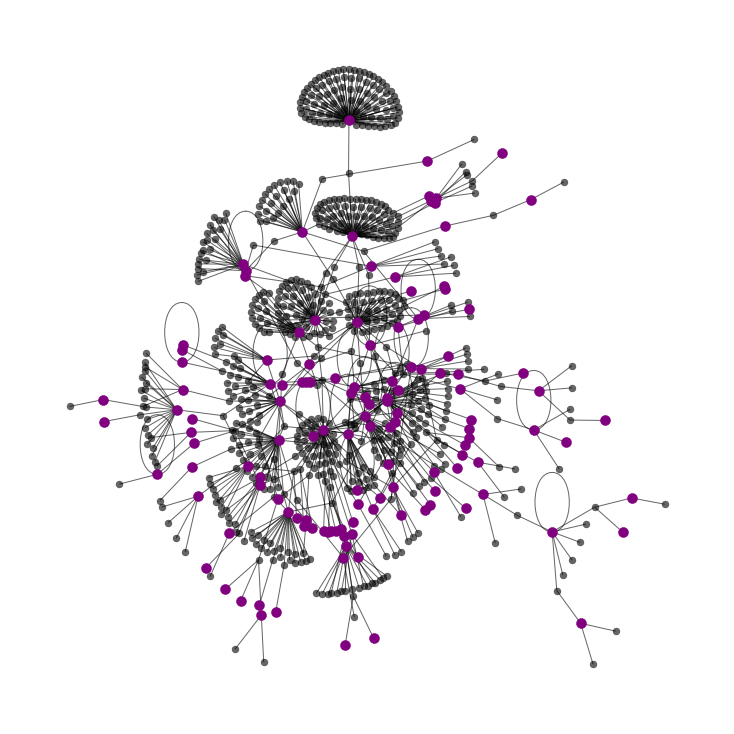

In [22]:
plot_network(center_df, 'purple')

There are 832 nodes and 806 edges present in the Graph
The maximum degree of the Graph is 46
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.9
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 127 connected components in the Graph
There are 479 nodes and 571   edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.0002986789705443764 in the largest subgraph
The transitivity of the largest subgraph is 0.0005736137667304016
The diameter of our Graph is 13
The average distance between any two nodes is 5.60
the node with id Cornish_Damo has a degree centrality of 0.10 which is the maximum of the Graph
the node with id pauldashworth has a closeness centrality of 0.31 which is the maximum of the Graph
the node with id pauldashworth has a betweenness centrality of 0.48 which is the maximum of the Graph


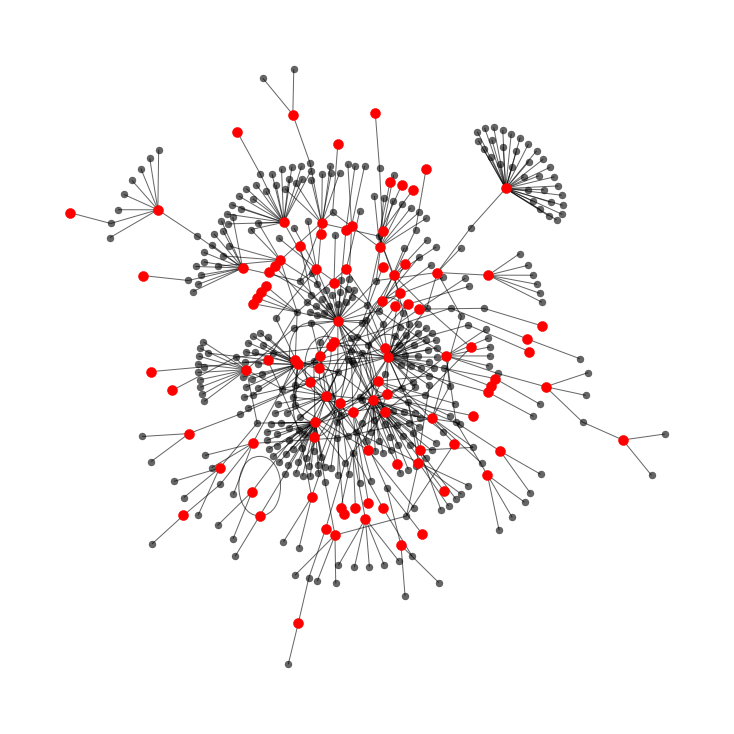

In [23]:
plot_network(left_df, 'red')

### Similarity Matrix

In [ ]:
pol_df = pol_df.sample(n=5000)

In [ ]:
pol_df = pol_df.reset_index(drop=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(pol_df['quotedTweet_content'])
print(tfidf_matrix.shape)

(2895, 11052)


In [ ]:
pol_df['quotedTweet_content'][0]

"b'DISGUSTING: Man is given just \\xc2\\xa37 in Universal Credit to get him through Christmas. He has been forced to turn to his poorly mum for meals and is relying on electricity vouchers. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\\n\\nhttps://t.co/Rq3AwuybsO'"

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_index=cosine_similarity(tfidf_matrix[0],tfidf_matrix)
similarity_index=similarity_index.reshape(-1)

In [ ]:
n=6
print(similarity_index[np.argsort(similarity_index)[-n:]])

[0.24647499 0.24647499 1.         1.         1.         1.        ]


In [ ]:
res = sorted(range(len(similarity_index)), key = lambda sub: similarity_index[sub])[-n:] 
  
# printing result 
print("Indices list of max N elements is : " + str(res))

Indices list of max N elements is : [8, 9, 0, 2, 11, 12]


In [ ]:
for i in res:
    print(pol_df['quotedTweet_content'][i], i)
    print('\n')

b'DISGRACEFUL: Woman on drip forced to lay on chairs for five hours at overcrowded hospital. She suffers from suspected kidney infection, and forced to wait on the makeshift bed. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\n\nhttps://t.co/CSnUaDYseQ' 8


b'DISGRACEFUL: Woman on drip forced to lay on chairs for five hours at overcrowded hospital. She suffers from suspected kidney infection, and forced to wait on the makeshift bed. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\n\nhttps://t.co/CSnUaDYseQ' 9


b'DISGUSTING: Man is given just \xc2\xa37 in Universal Credit to get him through Christmas. He has been forced to turn to his poorly mum for meals and is relying on electricity vouchers. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\n\nhttps://t.co/Rq3AwuybsO' 0


b'DISGUSTING: Man is given just \xc2\xa37 in Universal Credit to get him through Christmas. He has been forced to turn to his poorly mum for meals an

In [ ]:
tfidf_matrix

<2895x11052 sparse matrix of type '<class 'numpy.float64'>'
	with 72448 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(affinity='cosine', linkage='single', distance_threshold=0, n_clusters=None).fit(tfidf_matrix.toarray())


In [ ]:
cluster

AgglomerativeClustering(affinity='cosine', distance_threshold=0,
                        linkage='single', n_clusters=None)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

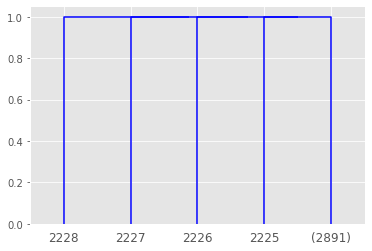

In [ ]:
plot_dendrogram(cluster, truncate_mode='level', p=3)
plt.show()

In [ ]:
tfidf = TfidfVectorizer(max_features=100)
X = tfidf.fit_transform(pol_df['quotedTweet_content']).todense()

In [ ]:
N = X.shape[0]
idx = np.random.choice(N, size=1000, replace=False)
x = X[idx]
labels = pol_df.quotedTweet_username[idx].tolist()


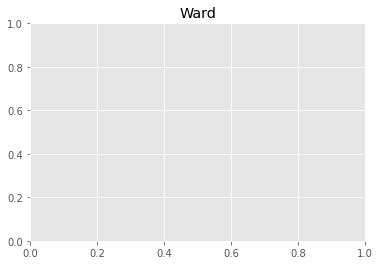

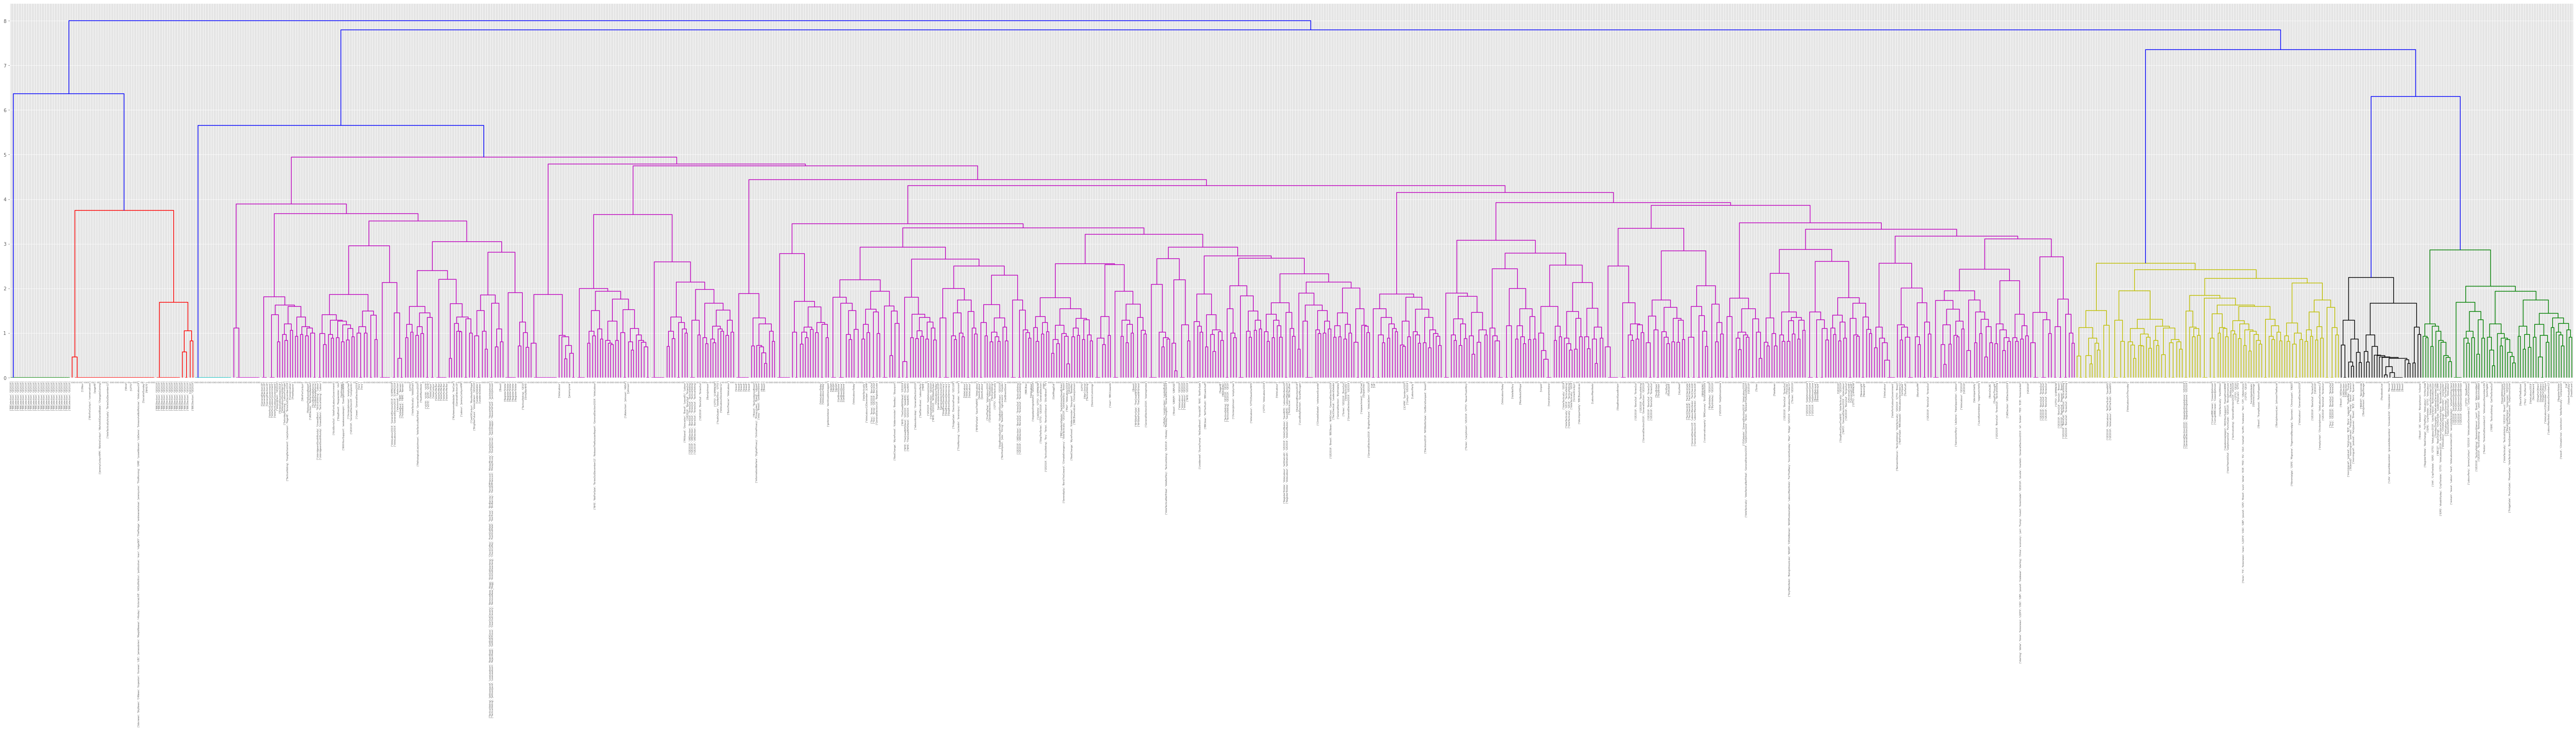

In [ ]:
from scipy.spatial.distance import pdist
dist_array = pdist(x)
Z = linkage(dist_array, 'ward')
plt.title("Ward")
plt.figure(figsize = (100,15))
dendrogram(Z, labels=labels)
plt.show()

In [ ]:
dist_array

array([1.36251384, 1.35023272, 1.29156013, ..., 1.37277395, 1.3425914 ,
       1.16012702])

In [ ]:
from sklearn import manifold
